In [14]:
import os
import datetime as dt
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = (
    os.environ.get("SUPABASE_SERVICE_ROLE_KEY")
    or os.environ.get("SUPABASE_API_KEY")
    or os.environ.get("SUPABASE_ANON_KEY")
)

if not SUPABASE_URL or not SUPABASE_KEY:
    raise RuntimeError("Set SUPABASE_URL and SUPABASE_KEY in environment.")

In [15]:
def fetch_macro_state_daily(start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    endpoint = f"{SUPABASE_URL}/rest/v1/macro_state_daily"
    headers = {
        "apikey": SUPABASE_KEY,
        "Authorization": f"Bearer {SUPABASE_KEY}",
    }
    params_base = {
        "select": ",".join(
            [
                "date",
                "regime_id",
                "regime_label",
                "stress_score",
                "hmm_score_0_100",
                "prob_state_0",
                "prob_state_1",
                "prob_state_2",
                "prob_state_3",
            ]
        ),
        "date": [f"gte.{start_date.isoformat()}", f"lte.{end_date.isoformat()}"],
        "order": "date.asc",
        "limit": 1000,
    }

    rows = []
    offset = 0
    while True:
        params = params_base.copy()
        params["offset"] = offset
        resp = requests.get(endpoint, headers=headers, params=params, timeout=30)
        resp.raise_for_status()
        batch = resp.json()
        rows.extend(batch)
        if len(batch) < 1000:
            break
        offset += 1000

    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"])
    return df

In [16]:
end = dt.date.today()
start = end - dt.timedelta(days=365)

macro = fetch_macro_state_daily(start, end)
macro.head()

,date,regime_id,regime_label,stress_score,hmm_score_0_100,prob_state_0,prob_state_1,prob_state_2,prob_state_3
0,2025-01-23,3,Stagflation,0.000000,99.999995,1.134300e-08,3.831296e-08,1.889283e-53,1.000000
1,2025-01-24,3,Stagflation,0.000000,99.983872,9.283749e-06,1.591277e-04,6.982295e-52,0.999832
2,2025-01-27,3,Stagflation,0.542349,3.633889,1.893519e-01,8.106481e-01,2.958012e-46,0.000000
3,2025-01-28,3,Stagflation,0.000000,28.784724,3.975376e-03,7.414127e-01,9.418372e-51,0.254612
4,2025-01-29,3,Stagflation,0.155897,4.290026,4.298107e-02,9.570189e-01,7.061271e-47,0.000000


In [17]:
# fetch SPX (^GSPC) and align
# Using multi_level_index=False to avoid MultiIndex columns (yfinance >= 0.2)
spx = yf.download(
    "^GSPC", 
    start=start.isoformat(), 
    end=(end + dt.timedelta(days=1)).isoformat(), 
    progress=False,
    multi_level_index=False
)

spx = spx.rename(columns=str.lower)
spx = spx[["close"]].reset_index()
spx["date"] = pd.to_datetime(spx["Date"] if "Date" in spx.columns else spx["date"])
spx = spx[["date", "close"]].set_index("date").sort_index()

# normalize SPX to 100 at start
spx["spx_norm"] = 100.0 * spx["close"] / spx["close"].iloc[0]

if "date" in macro.columns:
    macro_indexed = macro.set_index("date").sort_index()
else:
    macro_indexed = macro.sort_index()
    
df = macro_indexed.join(spx[["spx_norm"]], how="inner")

df.head()

,regime_id,regime_label,stress_score,hmm_score_0_100,prob_state_0,prob_state_1,prob_state_2,prob_state_3,spx_norm
date,,,,,,,,,
2025-01-23,3,Stagflation,0.000000,99.999995,1.134300e-08,3.831296e-08,1.889283e-53,1.000000,100.000000
2025-01-24,3,Stagflation,0.000000,99.983872,9.283749e-06,1.591277e-04,6.982295e-52,0.999832,99.714487
2025-01-27,3,Stagflation,0.542349,3.633889,1.893519e-01,8.106481e-01,2.958012e-46,0.000000,98.260578
2025-01-28,3,Stagflation,0.000000,28.784724,3.975376e-03,7.414127e-01,9.418372e-51,0.254612,99.166331
2025-01-29,3,Stagflation,0.155897,4.290026,4.298107e-02,9.570189e-01,7.061271e-47,0.000000,98.702342


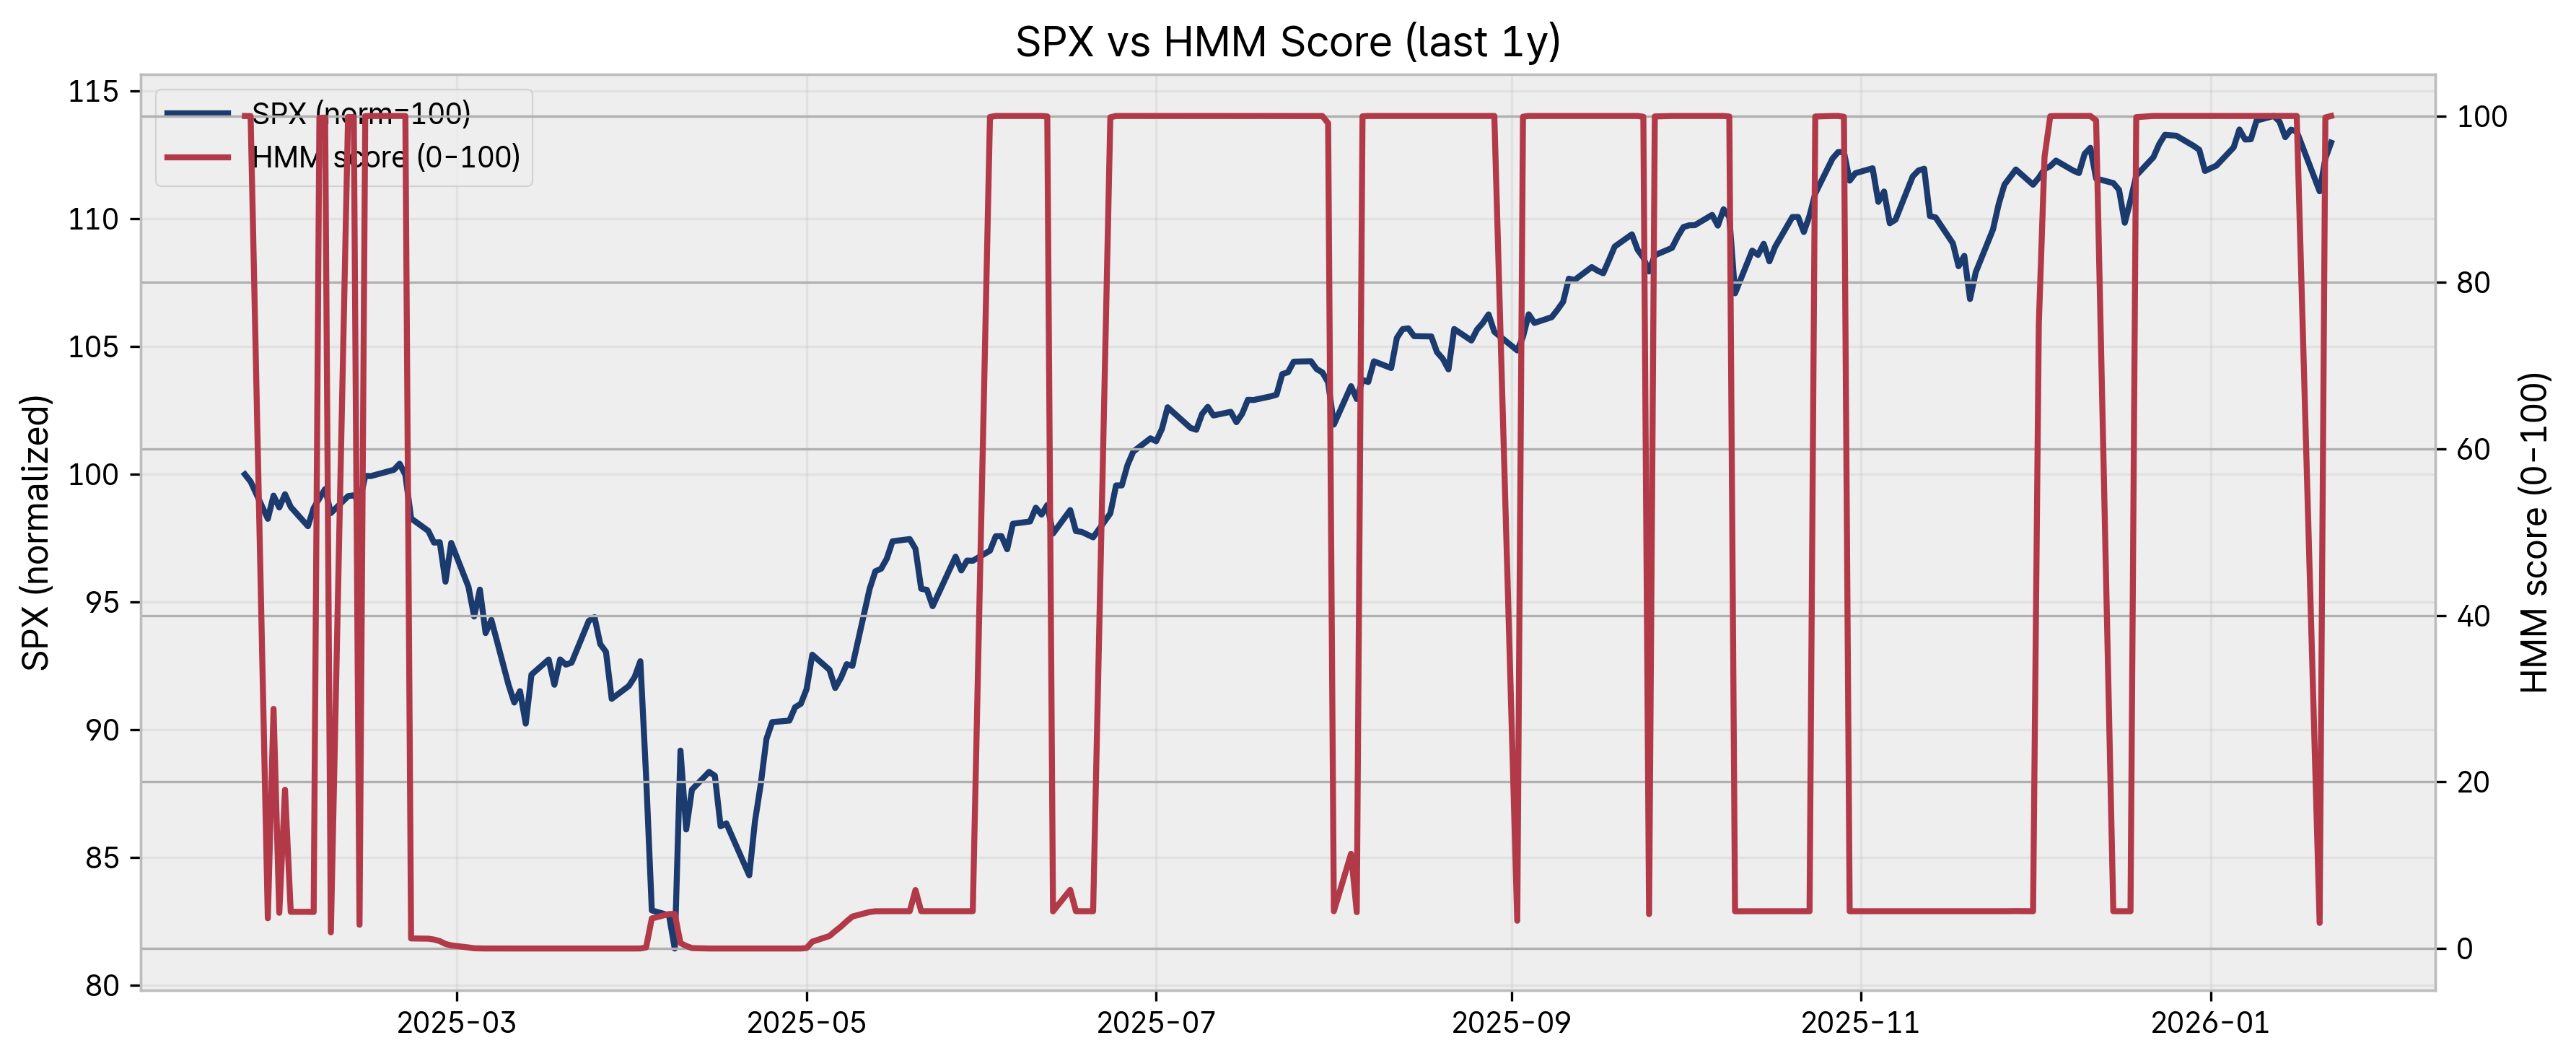

In [18]:
# plot SPX vs HMM score
plt.figure(figsize=(12, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df.index, df["spx_norm"], color="#1b3b6f", label="SPX (norm=100)")
ax2.plot(df.index, df["hmm_score_0_100"], color="#b23a48", label="HMM score (0-100)")

ax1.set_ylabel("SPX (normalized)")
ax2.set_ylabel("HMM score (0-100)")
ax1.set_title("SPX vs HMM Score (last 1y)")
ax1.grid(True, alpha=0.2)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")
plt.tight_layout()
plt.show()

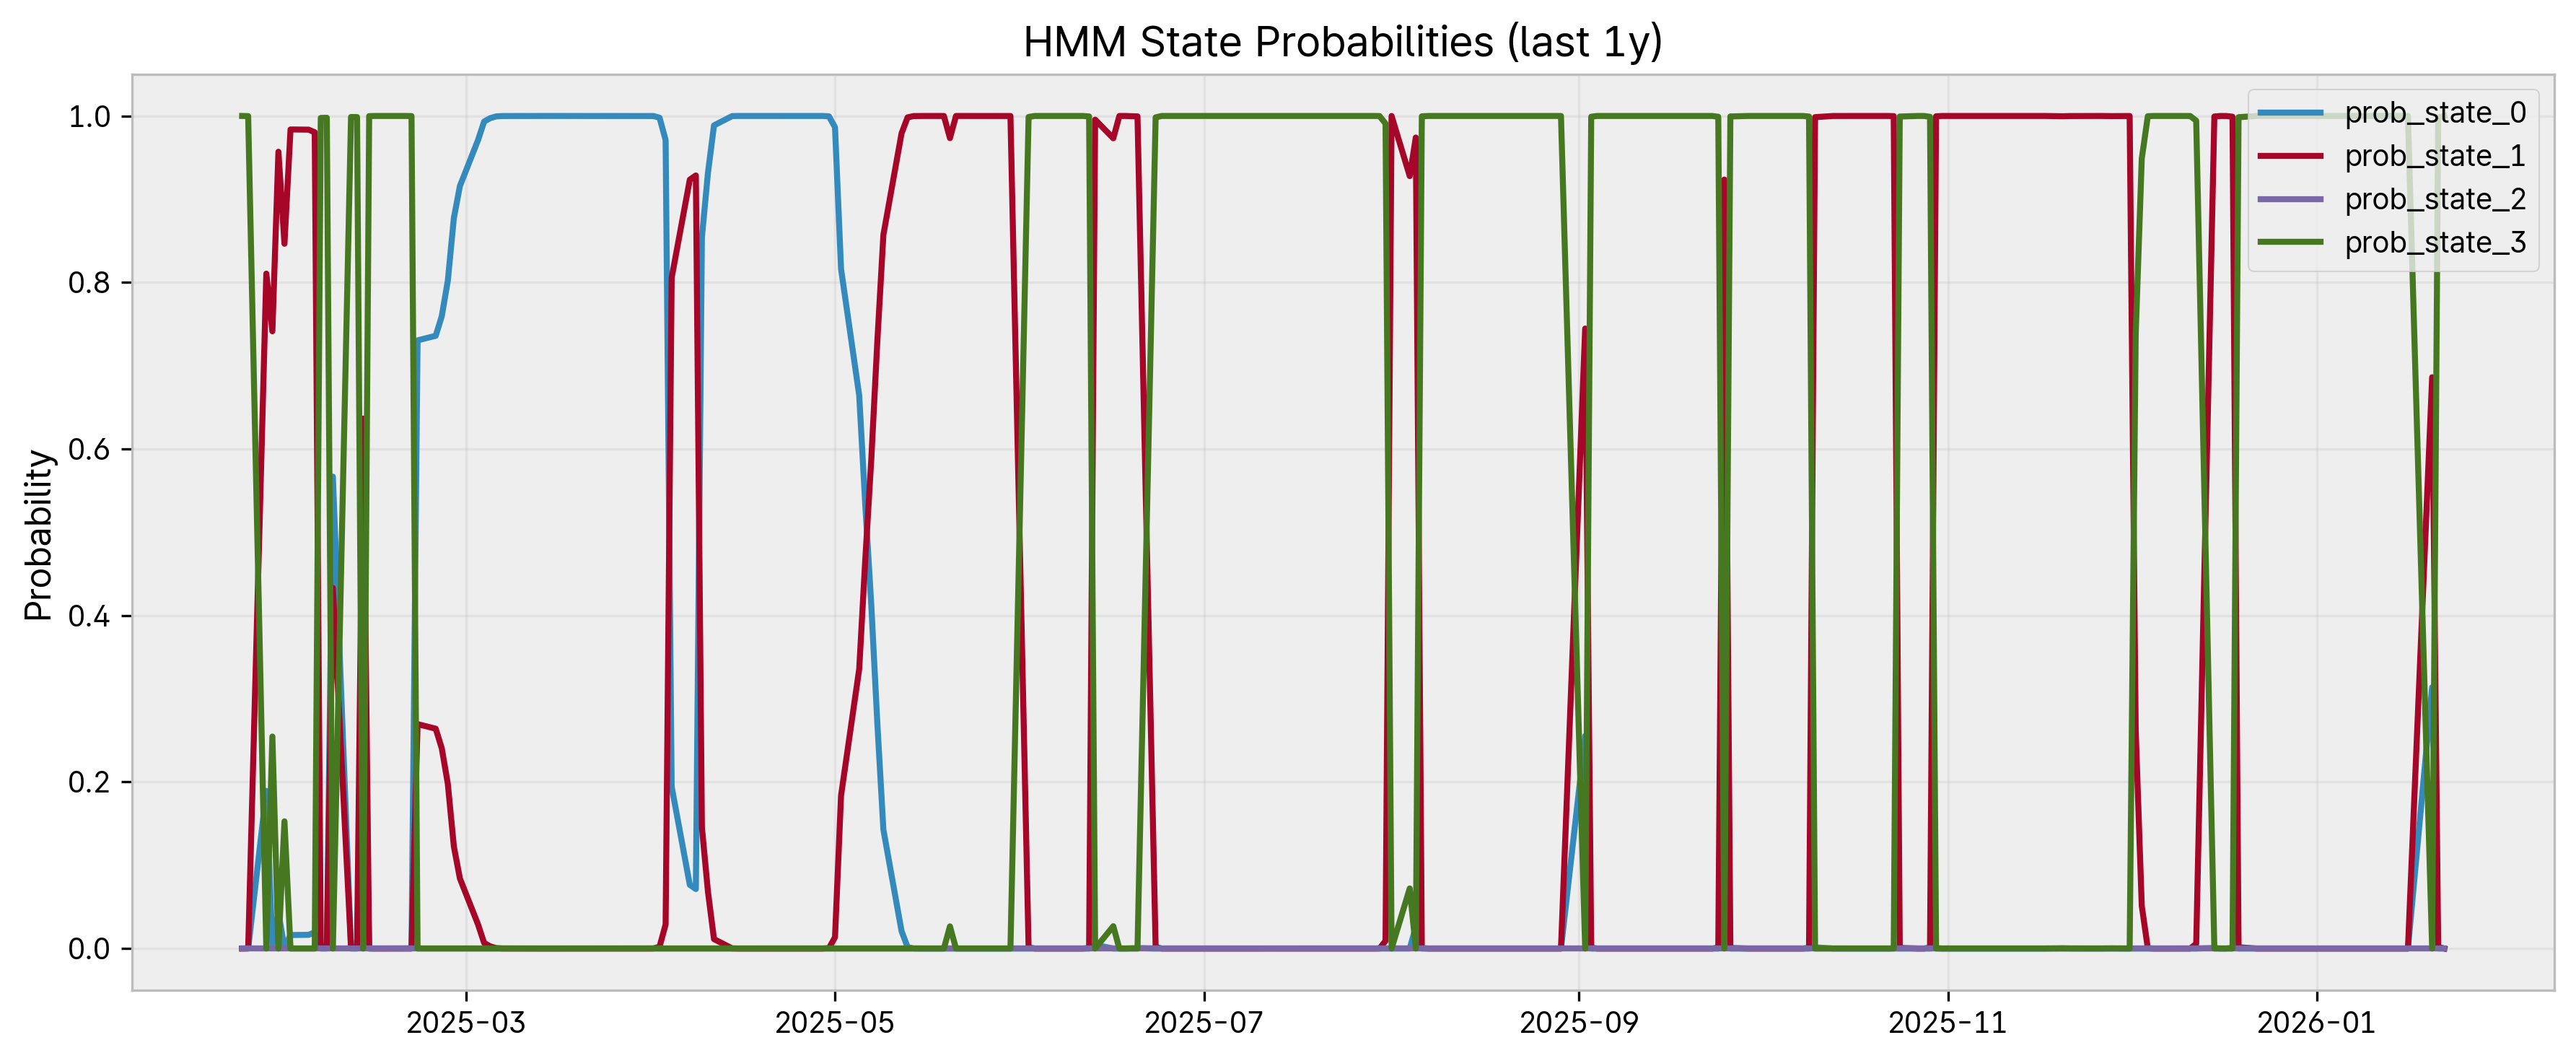

In [19]:
# plot prob_state lines
plt.figure(figsize=(12, 5))
for k in range(4):
    col = f"prob_state_{k}"
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)

plt.title("HMM State Probabilities (last 1y)")
plt.ylabel("Probability")
plt.grid(True, alpha=0.2)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()